In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random
from collections import deque

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import yfinance as yf

# https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

#try changing around the optimizer

# Reproducability
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [2]:

#units = neurons
def load_data(ticker, period, interval, n_steps=50, scale=True, shuffle=True, lookup_step=1, test_size=.2,
              feature_columns=['Close', 'Volume', 'Open', 'High', 'Low']):
    '''
    :param ticker: Ticker you want to load, dtype: str
    :param period: Time period you want data from, dtype: str(options in program)
    :param interval: Interval for data, dtype:str
    :param n_steps: Past sequence len used to predict, default = 50, dtype: int
    :param scale: Whether to scale data b/w 0 and 1, default = True, dtype: Bool
    :param shuffle: Whether to shuffle data, default = True, dtyper: Bool
    :param lookup_step: Future lookup step to predict, default = 1(next day), dtype:int
    :param test_size: ratio for test data, default is .2 (20% test data), dtype: float
    :param feature_columns: list of features fed into the model, default is OHLCV, dtype: list
    :return:
    '''
    df = yf.download(tickers=ticker, period=period, interval=interval,
                     group_by='ticker',
                     # adjust all OHLC automatically
                     auto_adjust=True, prepost=True, threads=True, proxy=None)

    #print("removing last day for testing by damian")
    #df = df.iloc[:-16 , :].copy()
    #print(df.tail())
    
    
    result = {}
    result['df'] = df.copy()

    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['Close'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    last_sequence = np.array(last_sequence)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y,
                                                                               test_size=test_size, shuffle=shuffle)
    # return the result
    return result

#Again, this function is flexible too, and you can change the number of layers, dropout rate, the RNN cell, loss, and the optimizer used to compile the model.

#The above function constructs an RNN with a dense layer as an output layer with one neuron. This model requires a sequence of features of sequence_length (in this case, we will pass 50 or 100) consecutive time steps (which are days in this dataset) and outputs a single value which indicates the price of the next time step.

#It also accepts n_features as an argument, which is the number of features we will pass on each sequence, in our case, we'll pass adjclose, open, high, low and volume columns (i.e 5 features).

#You can tweak the default parameters as you wish, n_layers is the number of RNN layers you want to stack, dropout is the dropout rate after each RNN layer, units are the number of RNN cell units (whether it is LSTM, SimpleRNN, or GRU), bidirectional is a boolean that indicates whether to use bidirectional RNNs, experiment with those!


def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="adam", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [16]:
N_STEPS = 70
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
PERIOD = '2y'
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
INTERVAL = '1d'
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.3
# features to use
FEATURE_COLUMNS = ["Close", "Volume", "Open", "High", "Low"]
# date now
date_now = time.strftime("%Y-%m-%d")

# > model parameters <
N_LAYERS = 3  # 3
#Type of model
CELL = LSTM
# Number of neurons
UNITS = 256
# Dropout rate
DROPOUT = 0.4  # 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

# > training parameters <
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 200
ticker = "SPY"

#save model
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

# folders that store results
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

data = load_data(ticker, PERIOD, INTERVAL, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv()
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    #callbacks=[checkpointer, tensorboard],
                    verbose=1)
model.save(os.path.join("results", model_name) + ".h5")

# >> Testing the Model <<

data = load_data(ticker, PERIOD, INTERVAL, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["Close"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)





[*********************100%***********************]  1 of 1 completed
Epoch 1/200
5/5 [==============================] - 5s 405ms/step - loss: 0.0657 - mean_absolute_error: 0.2843 - val_loss: 0.0240 - val_mean_absolute_error: 0.1853
Epoch 2/200
5/5 [==============================] - 1s 228ms/step - loss: 0.0237 - mean_absolute_error: 0.1834 - val_loss: 0.0380 - val_mean_absolute_error: 0.2066
Epoch 3/200
5/5 [==============================] - 1s 226ms/step - loss: 0.0201 - mean_absolute_error: 0.1554 - val_loss: 0.0221 - val_mean_absolute_error: 0.1776
Epoch 4/200
5/5 [==============================] - 1s 227ms/step - loss: 0.0206 - mean_absolute_error: 0.1692 - val_loss: 0.0296 - val_mean_absolute_error: 0.1822
Epoch 5/200
5/5 [==============================] - 1s 224ms/step - loss: 0.0185 - mean_absolute_error: 0.1463 - val_loss: 0.0177 - val_mean_absolute_error: 0.1598
Epoch 6/200
5/5 [==============================] - 1s 225ms/step - loss: 0.0169 - mean_absolute_error: 0.1530 - val_

5/5 [==============================] - 1s 221ms/step - loss: 0.0035 - mean_absolute_error: 0.0658 - val_loss: 0.0028 - val_mean_absolute_error: 0.0599
Epoch 51/200
5/5 [==============================] - 1s 224ms/step - loss: 0.0036 - mean_absolute_error: 0.0658 - val_loss: 0.0042 - val_mean_absolute_error: 0.0756
Epoch 52/200
5/5 [==============================] - 1s 222ms/step - loss: 0.0037 - mean_absolute_error: 0.0678 - val_loss: 0.0027 - val_mean_absolute_error: 0.0592
Epoch 53/200
5/5 [==============================] - 1s 220ms/step - loss: 0.0030 - mean_absolute_error: 0.0625 - val_loss: 0.0028 - val_mean_absolute_error: 0.0595
Epoch 54/200
5/5 [==============================] - 1s 227ms/step - loss: 0.0032 - mean_absolute_error: 0.0636 - val_loss: 0.0029 - val_mean_absolute_error: 0.0594
Epoch 55/200
5/5 [==============================] - 1s 223ms/step - loss: 0.0033 - mean_absolute_error: 0.0643 - val_loss: 0.0027 - val_mean_absolute_error: 0.0583
Epoch 56/200
5/5 [===========

5/5 [==============================] - 1s 208ms/step - loss: 0.0028 - mean_absolute_error: 0.0561 - val_loss: 0.0024 - val_mean_absolute_error: 0.0555
Epoch 101/200
5/5 [==============================] - 1s 227ms/step - loss: 0.0026 - mean_absolute_error: 0.0570 - val_loss: 0.0024 - val_mean_absolute_error: 0.0550
Epoch 102/200
5/5 [==============================] - 1s 219ms/step - loss: 0.0028 - mean_absolute_error: 0.0590 - val_loss: 0.0027 - val_mean_absolute_error: 0.0568
Epoch 103/200
5/5 [==============================] - 1s 220ms/step - loss: 0.0030 - mean_absolute_error: 0.0621 - val_loss: 0.0028 - val_mean_absolute_error: 0.0582
Epoch 104/200
5/5 [==============================] - 1s 228ms/step - loss: 0.0031 - mean_absolute_error: 0.0617 - val_loss: 0.0023 - val_mean_absolute_error: 0.0533
Epoch 105/200
5/5 [==============================] - 1s 220ms/step - loss: 0.0022 - mean_absolute_error: 0.0519 - val_loss: 0.0025 - val_mean_absolute_error: 0.0575
Epoch 106/200
5/5 [=====

Epoch 150/200
5/5 [==============================] - 1s 212ms/step - loss: 0.0022 - mean_absolute_error: 0.0516 - val_loss: 0.0022 - val_mean_absolute_error: 0.0529
Epoch 151/200
5/5 [==============================] - 1s 217ms/step - loss: 0.0021 - mean_absolute_error: 0.0513 - val_loss: 0.0021 - val_mean_absolute_error: 0.0530
Epoch 152/200
5/5 [==============================] - 1s 214ms/step - loss: 0.0020 - mean_absolute_error: 0.0491 - val_loss: 0.0021 - val_mean_absolute_error: 0.0506
Epoch 153/200
5/5 [==============================] - 1s 218ms/step - loss: 0.0021 - mean_absolute_error: 0.0512 - val_loss: 0.0021 - val_mean_absolute_error: 0.0509
Epoch 154/200
5/5 [==============================] - 1s 218ms/step - loss: 0.0019 - mean_absolute_error: 0.0482 - val_loss: 0.0020 - val_mean_absolute_error: 0.0516
Epoch 155/200
5/5 [==============================] - 1s 214ms/step - loss: 0.0020 - mean_absolute_error: 0.0499 - val_loss: 0.0020 - val_mean_absolute_error: 0.0516
Epoch 156/

Epoch 200/200
5/5 [==============================] - 1s 222ms/step - loss: 0.0017 - mean_absolute_error: 0.0477 - val_loss: 0.0020 - val_mean_absolute_error: 0.0497
[*********************100%***********************]  1 of 1 completed
Mean Absolute Error: 359.4286198395316


In [17]:
def predict(model, data):
    last_sequence = data["last_sequence"][-N_STEPS:]
    column_scaler = data["column_scaler"]
    # Swap dimensions
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["Close"].inverse_transform(prediction)[0][0]
    return predicted_price

# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

1/1 [==============================] - 1s 1s/step
Future price after 1 days is 392.46$


5/5 [==============================] - 0s 35ms/step


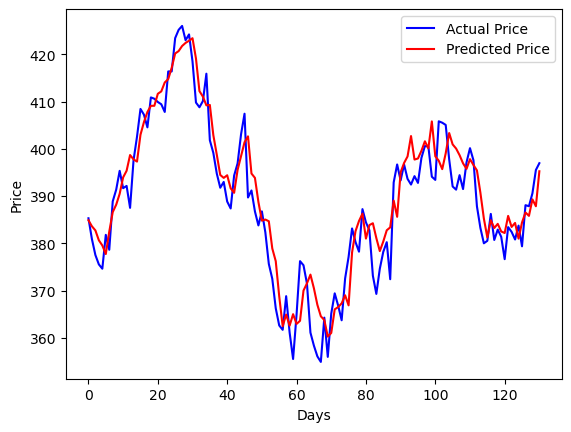

In [18]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["Close"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["Close"].inverse_transform(y_pred))
    # currently last 200 days
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

plot_graph(model, data)



In [19]:
def accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["Close"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["Close"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

print(str(LOOKUP_STEP) + ":", "Accuracy Score:", accuracy(model, data))

5/5 [==============================] - 0s 35ms/step
1: Accuracy Score: 0.5538461538461539


In [20]:
data["df"]

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-13,367.742493,369.849744,366.926780,368.810699,45303600
2021-01-14,369.587625,370.112022,367.169617,367.519196,49989100
2021-01-15,365.829492,366.664616,362.896807,364.838989,107160000
2021-01-19,367.402638,368.266924,365.858607,367.703674,51233300
2021-01-20,370.092604,373.666243,369.684763,372.792267,61836100
...,...,...,...,...,...
2023-01-06,382.609985,389.250000,379.410004,388.079987,104041300
2023-01-09,390.369995,393.700012,387.670013,387.859985,73978100
2023-01-10,387.250000,390.649994,386.269989,390.579987,65358100


In [31]:
data["y_test"].shape

(238,)

In [32]:
data["X_test"].shape

(238, 5, 70)

In [33]:
data["X_train"].shape

(951, 5, 70)

In [34]:
data["y_train"].shape

(951,)

In [35]:
data["df"].shape

(1259, 5)

In [21]:
#model_path = os.path.join("results", model_name) + ".h5"
#model.load_weights(model_path)
model_path  #'results\\2023-01-07_XLF-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5'

'results\\2023-01-13_SPY-huber_loss-adam-LSTM-seq-70-step-1-layers-3-units-256.h5'

In [37]:
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

In [38]:
model.load_weights(model_path)

In [41]:
last_sequence = data["last_sequence"][-70:]
last_sequence.shape  # 5 features

(70, 5)

(1, 5, 70)

(5, 70)

In [21]:
def load_data_1(ticker, period, interval, n_steps=50, scale=True, shuffle=True, lookup_step=1, test_size=.2,
              feature_columns=['Close', 'Volume', 'Open', 'High', 'Low']):
    '''
    :param ticker: Ticker you want to load, dtype: str
    :param period: Time period you want data from, dtype: str(options in program)
    :param interval: Interval for data, dtype:str
    :param n_steps: Past sequence len used to predict, default = 50, dtype: int
    :param scale: Whether to scale data b/w 0 and 1, default = True, dtype: Bool
    :param shuffle: Whether to shuffle data, default = True, dtyper: Bool
    :param lookup_step: Future lookup step to predict, default = 1(next day), dtype:int
    :param test_size: ratio for test data, default is .2 (20% test data), dtype: float
    :param feature_columns: list of features fed into the model, default is OHLCV, dtype: list
    :return:
    '''
    df = yf.download(tickers=ticker, period=period, interval=interval,
                     group_by='ticker',
                     # adjust all OHLC automatically
                     auto_adjust=True, prepost=True, threads=True, proxy=None)
    
    return(df)

In [22]:
data1 = load_data_1('SPY', PERIOD, INTERVAL, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)


[*********************100%***********************]  1 of 1 completed


In [23]:
data1

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-07,365.227382,368.917517,365.042872,368.140656,68766800
2021-01-08,369.587607,370.461583,366.198508,370.238251,71677200
2021-01-11,366.926841,369.577901,366.800594,367.742554,51034700
2021-01-12,367.936746,368.878676,365.479857,367.820190,52547700
2021-01-13,367.742524,369.849775,366.926811,368.810730,45303600
...,...,...,...,...,...
2022-12-30,380.640015,382.579987,378.429993,382.429993,83975100
2023-01-03,384.369995,386.429993,377.829987,380.820007,74850700
2023-01-04,383.179993,385.880005,380.000000,383.760010,85934100


In [26]:
data1.iloc[:-16 , :]

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-07,365.227382,368.917517,365.042872,368.140656,68766800
2021-01-08,369.587607,370.461583,366.198508,370.238251,71677200
2021-01-11,366.926841,369.577901,366.800594,367.742554,51034700
2021-01-12,367.936746,368.878676,365.479857,367.820190,52547700
2021-01-13,367.742524,369.849775,366.926811,368.810730,45303600
...,...,...,...,...,...
2022-12-07,391.143858,393.831529,390.178291,391.362854,65927900
2022-12-08,393.333824,395.543648,391.472347,394.428772,60737900
2022-12-09,393.134716,395.802458,391.352889,391.482300,81367500


In [27]:
data1.iloc[:-17 , :]

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-07,365.227382,368.917517,365.042872,368.140656,68766800
2021-01-08,369.587607,370.461583,366.198508,370.238251,71677200
2021-01-11,366.926841,369.577901,366.800594,367.742554,51034700
2021-01-12,367.936746,368.878676,365.479857,367.820190,52547700
2021-01-13,367.742524,369.849775,366.926811,368.810730,45303600
...,...,...,...,...,...
2022-12-06,397.594260,398.161631,389.849824,392.029785,77972200
2022-12-07,391.143858,393.831529,390.178291,391.362854,65927900
2022-12-08,393.333824,395.543648,391.472347,394.428772,60737900
